# **Advanced Lane Lines detection** 
***
In this project we developed a procedure to detect lanes and it's curvature using computer vision. I followed course work examples step by step to build the pipeline. We will achieve this goal by following steps

   - Camera calibration and undistort video frames 
   - Transform the frame to birds-eye-view to avoid noisy pixels to detect the lanes
   - Apply color and gradient threshold transformation
   - Apply the histogram on thresholded image and detect left and right pixels which are part of the lanes
   - Detect the left and right lanes by sliding window and it's curvature
   - After detection of lanes overlay with original image
   
Finally run with project video and produce results


In [59]:
#importing some useful packages
import os, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
%matplotlib inline

## Camera Calibration
***
Camera calibration step is the first step in pipeline. Which help us in following way

  - undistort the images which improves the quality of geometric measurement
  - It will also improves pixel to meter conversion in the later steps
 
Camera calibration process consits of loading well known pattern chessboard images and detect the corners using
<code>cv2.findChessboardCorners()</code>. Once pattern is identified, use these points to call <code>cv2.calibrateCamera()</code> to identify distortion coefficient and camera matrix. Camera matrix consists of distance between 3D space to 2D space.

Using these two matrices, will undistort the images using opencv <code>cv2.undistort()</code>. Correctness of undistortion tested and rendered for one of the chessboard images. 


Initializing camera calibration


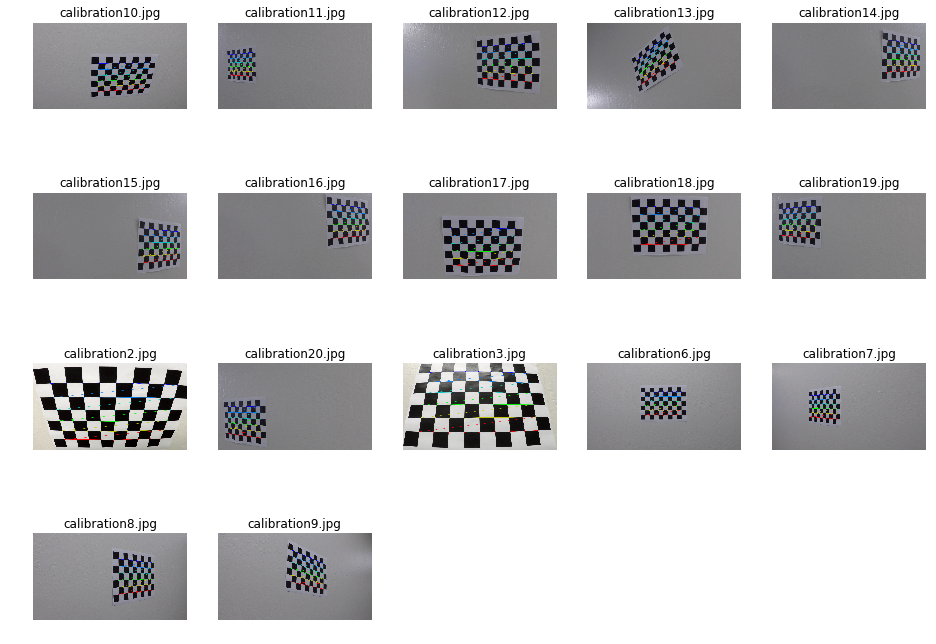

Calibration succesful


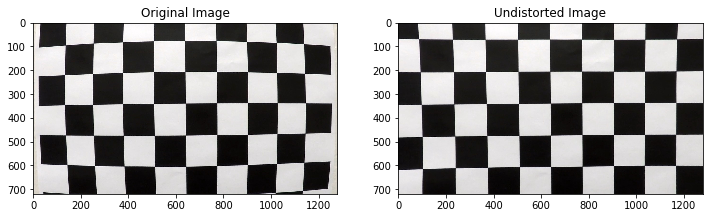

In [60]:
class Calibrator:
    """
    Camera calibtration based on provided chess board images from 'camrea_cal' directory
    """
    def __init__(self, image_dir, nx, ny):
        print("Initializing camera calibration")
        self.image_dir = image_dir
        self.nx = nx
        self.ny = ny
        self.mtx = None
        self.dist = None
        self.calibrated = False
        
    #camera calibration with calibration images    
    def calibrate(self, showPlot=False):
        file_list = glob.glob(self.image_dir + '/*.jpg')
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((self.nx * self.ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:self.nx,0:self.ny].T.reshape(-1,2)
        
        obj_points =[] #3D points in real space
        img_points = [] #2D points in image space
        
        if showPlot:
            img_count = len(file_list)
            cols = 5
            rows = int(img_count/cols)
            plt.figure(figsize=(16, 12))
            idx = 1
            
        for filename in file_list:
            img = plt.imread(filename) #RGB image
            #convert to gray scale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
            if ret == True:
                obj_points.append(objp)
                img_points.append(corners)
                
                if showPlot:
                    img = cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                    plt.subplot(rows, cols, idx)
                    plt.axis('off')
                    plt.title(filename.split('/')[-1])
                    plt.imshow(img)
                    idx += 1
        
        if showPlot:
            plt.show()
            
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        self.calibrated = True;
        print("Calibration succesful")
    
    #Undistort images
    def undistort(self, img):
        if not self.calibrated:
            calibrate(self.image_dir, self.nx, self.ny)
        undist_img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return undist_img
    
    def test_undistort(self, image_filename):
        img = plt.imread(self.image_dir +'/' + image_filename)
        undist_img = self.undistort(img)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.title('Undistorted Image')
        plt.imshow(undist_img)
        plt.show()
        
cal = Calibrator('camera_cal', 9, 6)
cal.calibrate(True)
cal.test_undistort('calibration1.jpg')

## Undistort test images

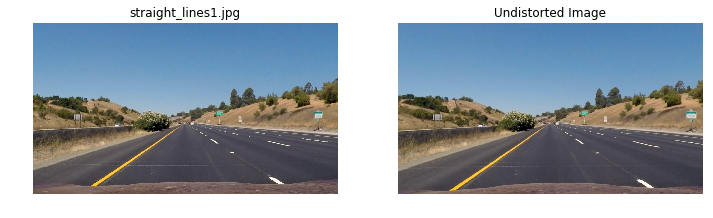

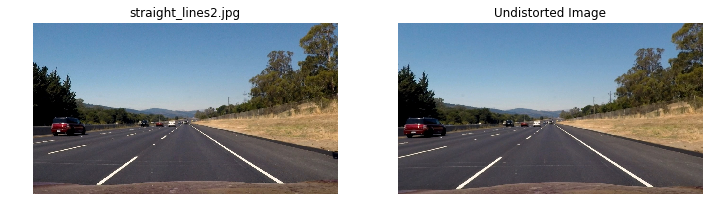

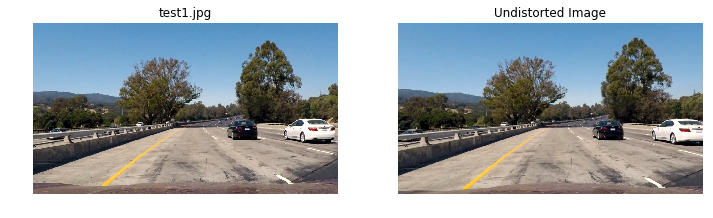

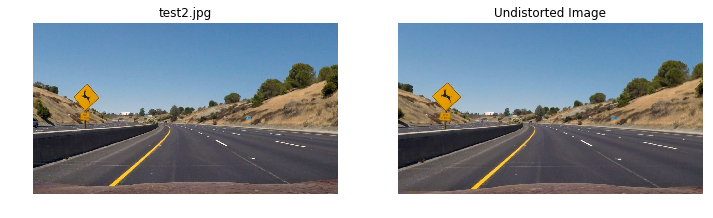

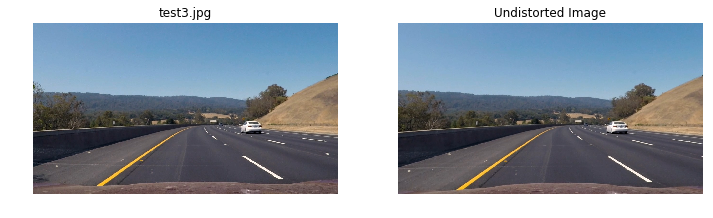

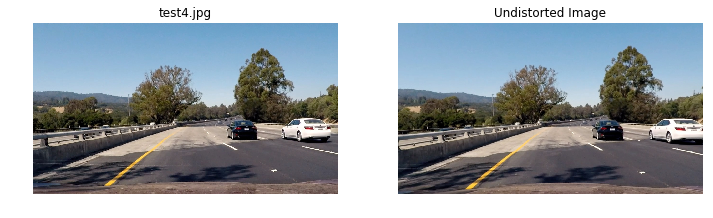

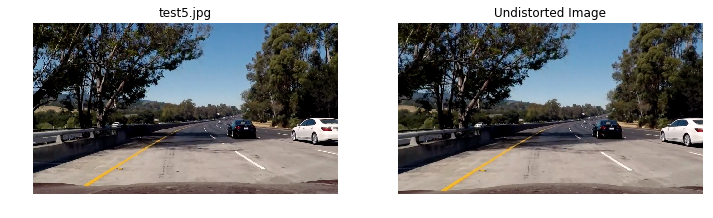

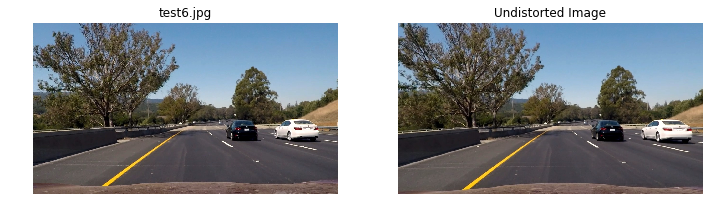

In [61]:
def test_undistort_on_images(image_dir):
    images = glob.glob(image_dir + '/*.jpg')
        
    for filename in images:
        img = plt.imread(filename)
        dist = cal.undistort(img)
        plt.figure(figsize = (12,8))
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title(filename.split('/')[-1])
        plt.imshow(img)
        
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title('Undistorted Image')
        plt.imshow(dist)
        
        plt.show()
        
test_undistort_on_images('test_images')

## Binary transformation
***
In order to get thresholded binary image, retrieved S channel from image and applied Sobel gradient. Parameters are tuned using trail and error which consumed most of the time. Following thresholds are applied to get final binary image

   - Extracted S channel from image and applied (170,255) thresholds 
   - Used Sobel gradient on x with threshold (20, 100) and kernel size 31 
   - Combined these two thresholds, we can retrieve bright pixels which are part of the lane lines

Verfied binary transformation of test images and ploted for visual inspection.

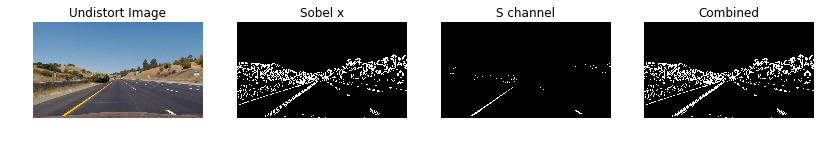

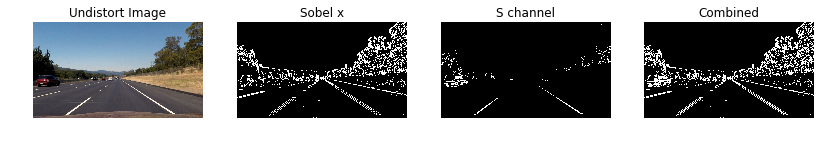

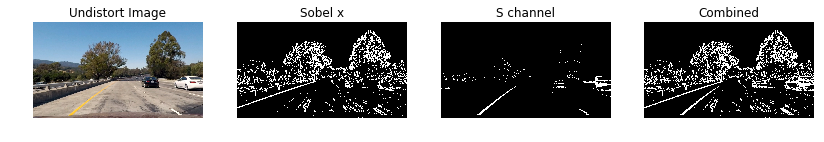

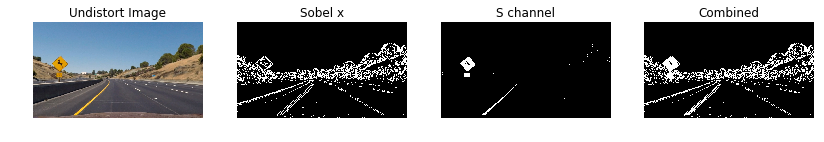

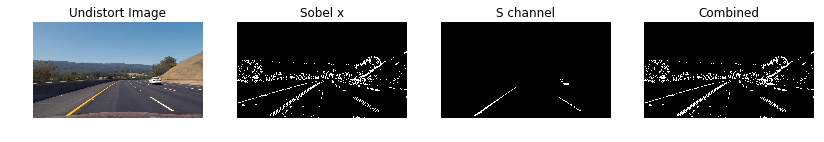

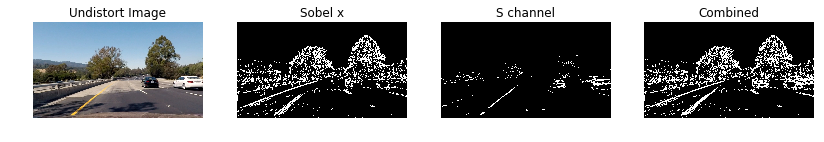

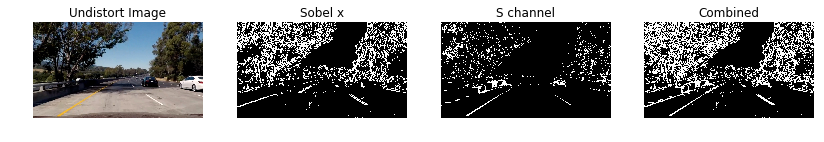

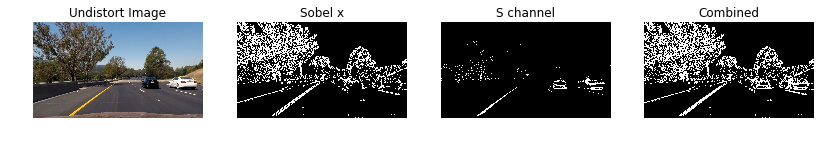

In [63]:
def color_transform(img, sobel_kernel=3, sc_thresh=(170, 255), sx_thresh=(20, 100), showPlot=False):
    img = np.copy(img)
    # Convert to HSV color space and separate the S channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    
    # Absolute derivative in x
    sobel_x_abs = np.absolute(sobel_x)
    
    scale_sobel_x = np.uint8(255*sobel_x_abs/np.max(sobel_x_abs))
    
    # Threshold x gradient
    sx_binary = np.zeros_like(scale_sobel_x)
    sx_binary[(scale_sobel_x >= sx_thresh[0]) & (scale_sobel_x <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sc_thresh[0]) & (s_channel <= sc_thresh[1])] = 1
    
    #sta_binary = np.dstack(( np.zeros_like(sx_binary), sx_binary, s_binary))

    # Create a binary flat image.
    final_binary = np.zeros_like(sx_binary)
    final_binary[(sx_binary == 1) | (s_binary == 1)] = 1
    
    if showPlot:
        plt.figure(figsize=(14, 10))
        plt.subplot(1, 4, 1)
        plt.axis('off')
        plt.title('Undistort Image')
        plt.imshow(img)
        
        plt.subplot(1, 4, 2)
        plt.axis('off')
        plt.title('Sobel x')
        plt.imshow(sx_binary, cmap='gray')
        
        plt.subplot(1, 4, 3)
        plt.axis('off')
        plt.title('S channel')
        plt.imshow(s_binary, cmap='gray')
        
        plt.subplot(1, 4, 4)
        plt.axis('off')
        plt.title('Combined')
        plt.imshow(final_binary, cmap='gray')
        
        plt.show()
        
    return final_binary

def test_binary_transform():
    images = glob.glob('test_images/*.jpg')
    for filename in images:
        img = plt.imread(filename)
        img = cal.undistort(img)
        color_transform(img, 31, showPlot=True)

test_binary_transform()
    

## Perspective & warp transformation 
***
Perspective & warp transformation convert real world image (after undistortion) to bird's eye view. In order to convert, we need to pick four points from real image and convert to bird's eye image with four destination points. This happen through trail and error. It's a tedious process to convert from real image to bird's eye view. 

Source point pickup is based on where both lanes looks like merge in the real image which is called a vanishing point. In the similar manner need to select a destination rectangle where both lanes looks parallel in bird's eye view.

Converted all the test images and verified perspective transformation.

Once we get perspective transformation, convert the image to gray and find out histogram where lane lines will have peaks in it. Which is used in further pipeline to detect the lanes.

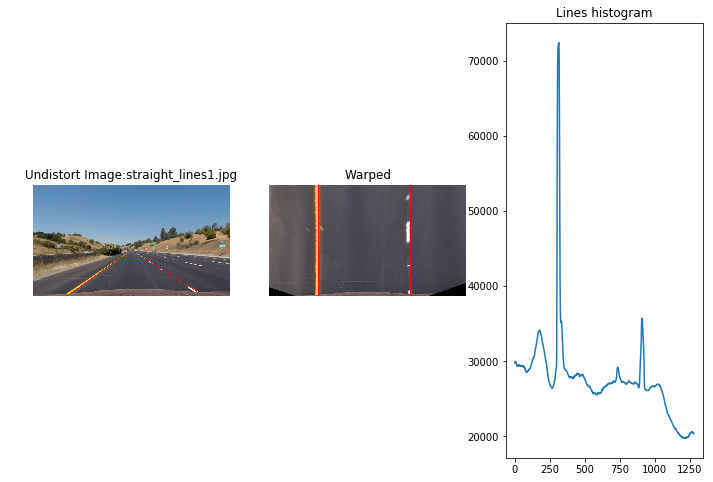

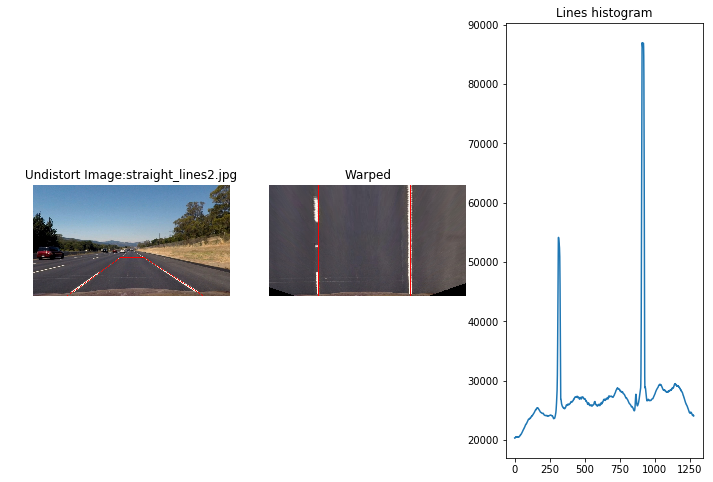

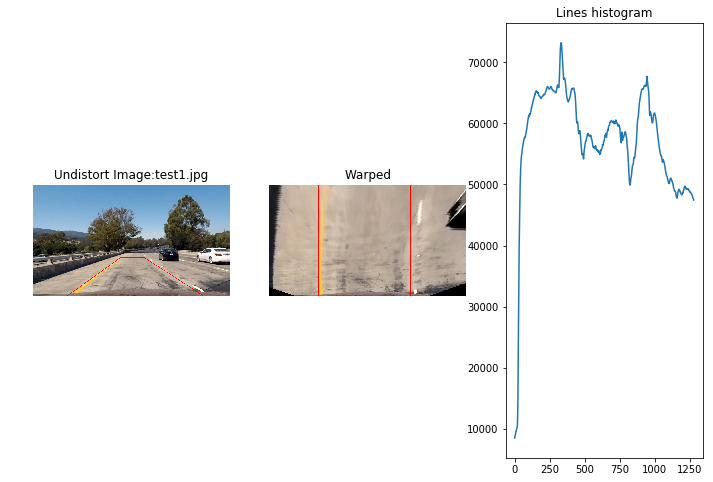

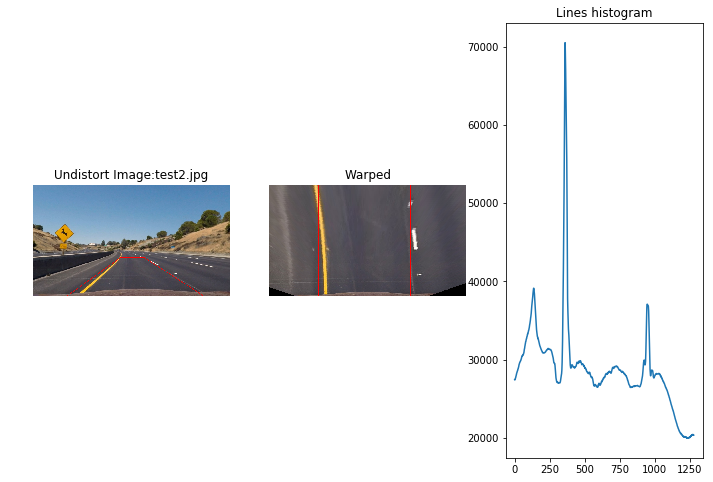

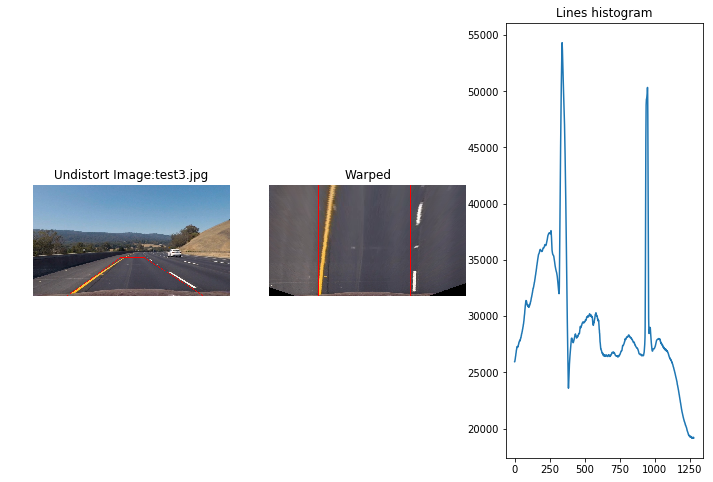

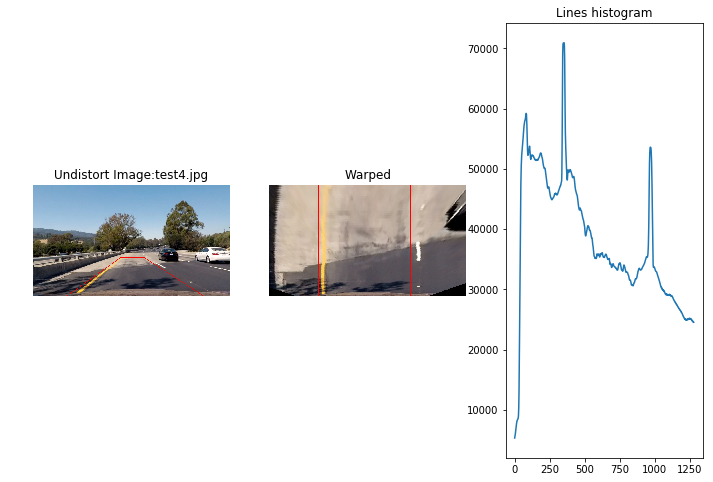

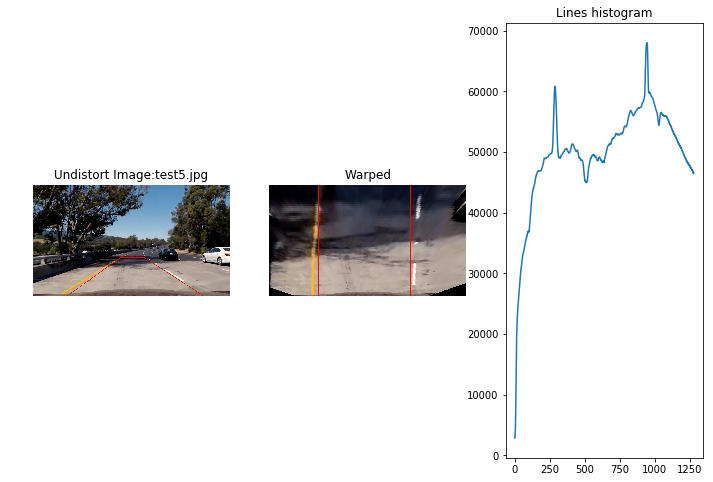

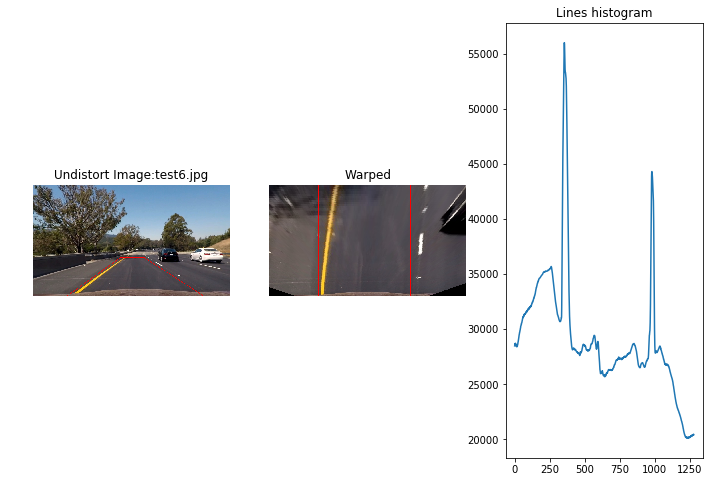

In [64]:
#points order in np array bottom left and right. Top right and left
#src = np.float32([[268,680], [1043, 680], [568,470], [717, 470]])
src = np.float32([[220, 720], [1110, 720], [722, 470], [570, 470]])
#dst = np.float32([[200, 0], [1000, 0], [200, 680],  [1000, 680]])
dst = np.float32([[320, 720], [920,720], [920,1], [320,1]])

def perspective_transform():
    M = cv2.getPerspectiveTransform(src, dst)
    return M

def warpperspective_transform(img, M):
    w = img.shape[1]
    h = img.shape[0]
    warp_img = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_NEAREST)
    
    return warp_img

def test_perspective_transform():
    images = glob.glob('test_images/*.jpg')
    M = perspective_transform();
    for filename in images:
        img = plt.imread(filename)
        img = cal.undistort(img)
        warped = warpperspective_transform(img, M)
        gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
        histogram = np.sum(gray[int(gray.shape[0]/2):,:], axis=0)
        
        cv2.polylines(img, np.array([src], np.int32), True, (255,0,0), 2)
        #print("image shape:", img.shape)
        cv2.polylines(warped, np.array([dst], np.int32), True, (255,0,0), 2)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 3, 1)
        plt.axis('off')
        plt.title('Undistort Image:' + filename.split('/')[-1])
        plt.imshow(img)
        
        plt.subplot(1, 3, 2)
        plt.axis('off')
        plt.title('Warped')
        plt.imshow(warped)
        
        plt.subplot(1, 3, 3)
        plt.title('Lines histogram')
        plt.plot(histogram)
    
        plt.show()

test_perspective_transform()

## Detecting lanes & curvature of the road
***
Applied following technique to find lanes and it's curvature

  - From histogram get the midpoint and divided into two halves
  - Find out left and right base points using midpoint through histogram
  - Using sliding window procedure fit the non zero pixels in each window
  - Once collected all the non zero pixels fit them with second order polynomial for left and right coordinates
  - Curvature of the lane can be derived analytically by applying tangent function in every point. It utilizes first 
    and second order derivatives
  - Converted pixel spaces to meters to identify real radius in meteres
  - Once converted to meteres identified car position in the image using midpoint of the image and lanes midpoint
  - Overlayed detected lanes on real image
  - For smooth display on the video, cached best fit points for n frames and avergae it over to display it. Which achieved in <code>advance_lane_detection()</code> function

left curve rad: 19027.6092871 , right curve rad: 11267.6719533
left curve rad: 6247.4447565 m , right curve rad: 3688.25613971 m
average radius: 4967.85044811 m


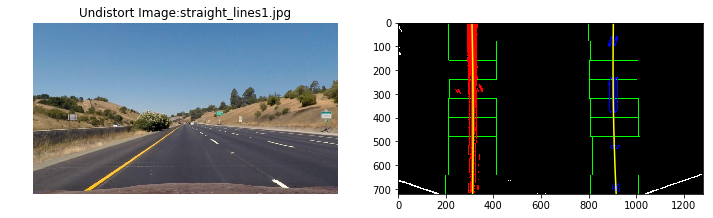

left curve rad: 23042.5734541 , right curve rad: 43052.1179465
left curve rad: 7567.92294577 m , right curve rad: 14137.7392556 m
average radius: 10852.8311007 m


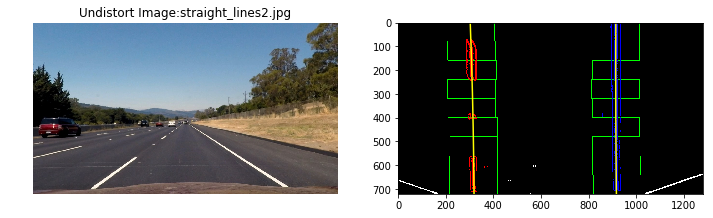

left curve rad: 4447.24441872 , right curve rad: 1449.47002202
left curve rad: 1454.44347893 m , right curve rad: 467.582627669 m
average radius: 961.0130533 m


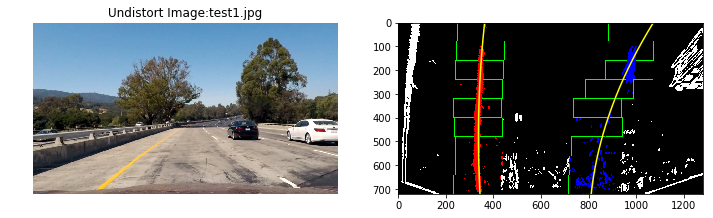

left curve rad: 3573.27131351 , right curve rad: 2020.92081716
left curve rad: 1173.54490887 m , right curve rad: 644.330489077 m
average radius: 908.937698975 m


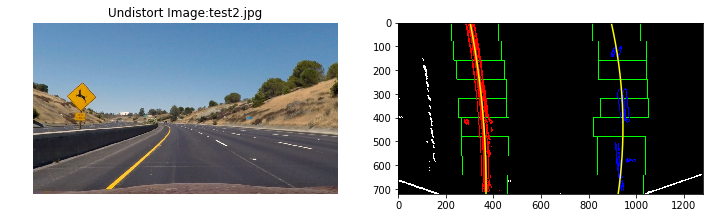

left curve rad: 5365.0864507 , right curve rad: 4052.01558729
left curve rad: 1756.67232409 m , right curve rad: 1330.84048981 m
average radius: 1543.75640695 m


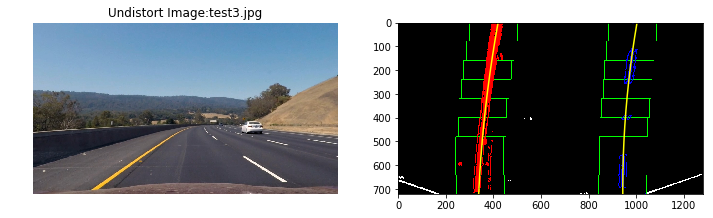

left curve rad: 14713.1668958 , right curve rad: 3516.61983485
left curve rad: 4819.89968854 m , right curve rad: 1078.77008403 m
average radius: 2949.33488628 m


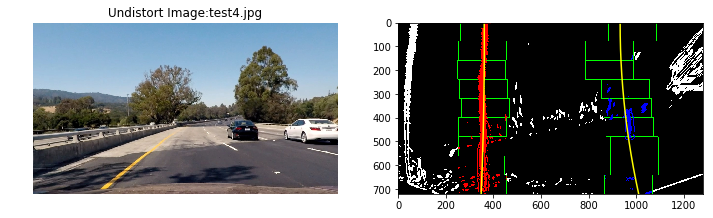

left curve rad: 3660.71760039 , right curve rad: 1123.03012991
left curve rad: 1200.53547487 m , right curve rad: 295.50203137 m
average radius: 748.018753119 m


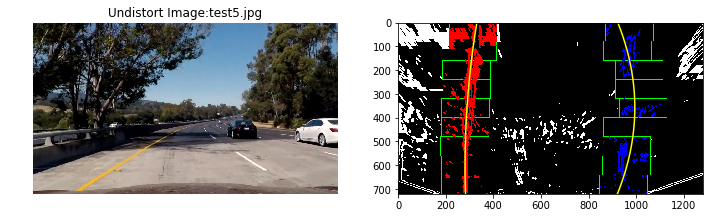

left curve rad: 5428.75408099 , right curve rad: 1647.28371648
left curve rad: 1773.04285356 m , right curve rad: 501.507386186 m
average radius: 1137.27511987 m


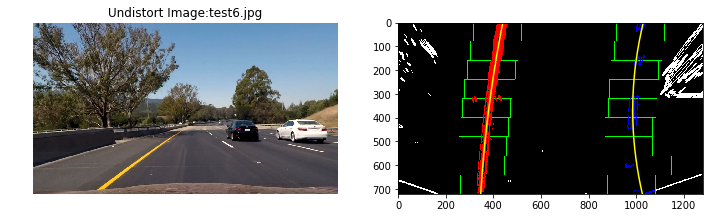

In [65]:
def detect_lanes(binary_warped, showPlot=False):
    #gray = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if showPlot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
            
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    y_eval = np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    if showPlot:
        print("left curve rad:", left_curverad, ", right curve rad:", right_curverad)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # new radius of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    if showPlot:
        # Now our radius of curvature is in meters
        print("left curve rad:", left_curverad, 'm', ", right curve rad:", right_curverad, 'm')
    
    #car position in meters
    m_car_pos = binary_warped.shape[1]/2
    #middle of the lane in meters
    m_lane = (left_fitx[0] + right_fitx[0])/2
    #offset from right to the center
    m_offset_from_right = (m_lane - m_car_pos)*xm_per_pix
    #average radius in meters
    m_avg_radius = np.mean([left_curverad, right_curverad])
    
    if showPlot :
        print ("average radius:", m_avg_radius, 'm')
        plt.subplot(1, 2, 2)
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return out_img, m_avg_radius, m_offset_from_right, left_fitx, right_fitx, ploty

def test_detect_lanes():
    images = glob.glob('test_images/*.jpg')
    M = perspective_transform();
    for filename in images:
        img = plt.imread(filename)
        img = cal.undistort(img)
        warped = warpperspective_transform(img, M)
        binary_warped = color_transform(warped, 31)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title('Undistort Image:' + filename.split('/')[-1])
        plt.imshow(img)
        
        detect_lanes(binary_warped, True)

test_detect_lanes()
    

left curve rad: 19027.6092871 , right curve rad: 11267.6719533
left curve rad: 6247.4447565 m , right curve rad: 3688.25613971 m
average radius: 4967.85044811 m


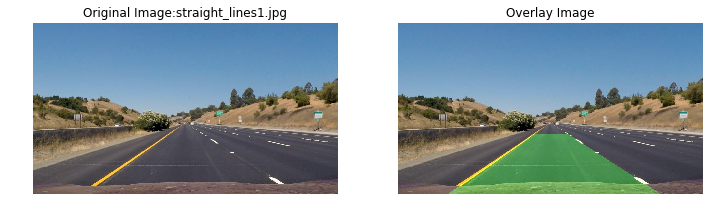

left curve rad: 23042.5734541 , right curve rad: 43052.1179465
left curve rad: 7567.92294577 m , right curve rad: 14137.7392556 m
average radius: 10852.8311007 m


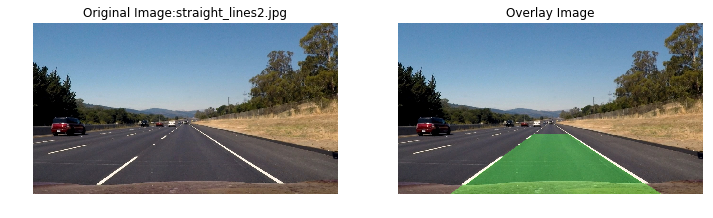

left curve rad: 4447.24441872 , right curve rad: 1449.47002202
left curve rad: 1454.44347893 m , right curve rad: 467.582627669 m
average radius: 961.0130533 m


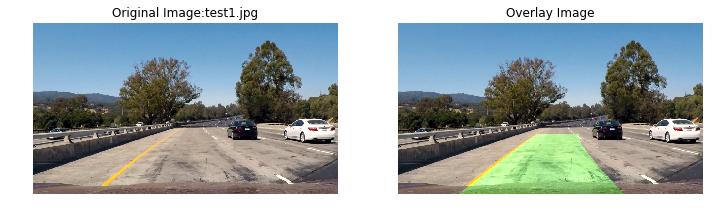

left curve rad: 3573.27131351 , right curve rad: 2020.92081716
left curve rad: 1173.54490887 m , right curve rad: 644.330489077 m
average radius: 908.937698975 m


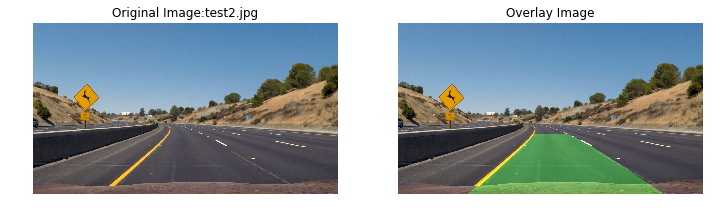

left curve rad: 5365.0864507 , right curve rad: 4052.01558729
left curve rad: 1756.67232409 m , right curve rad: 1330.84048981 m
average radius: 1543.75640695 m


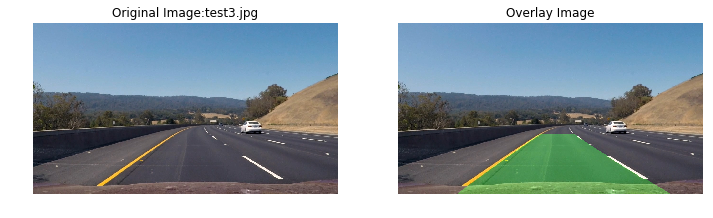

left curve rad: 14713.1668958 , right curve rad: 3516.61983485
left curve rad: 4819.89968854 m , right curve rad: 1078.77008403 m
average radius: 2949.33488628 m


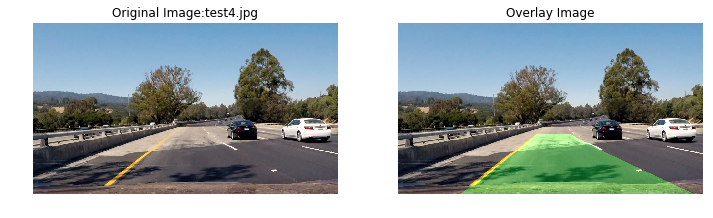

left curve rad: 3660.71760039 , right curve rad: 1123.03012991
left curve rad: 1200.53547487 m , right curve rad: 295.50203137 m
average radius: 748.018753119 m


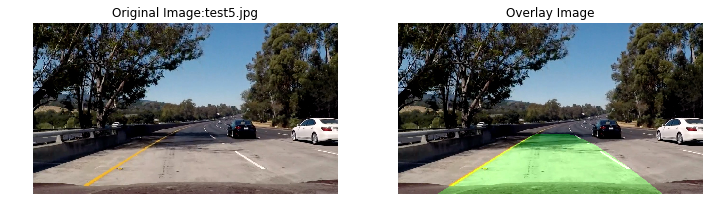

left curve rad: 5428.75408099 , right curve rad: 1647.28371648
left curve rad: 1773.04285356 m , right curve rad: 501.507386186 m
average radius: 1137.27511987 m


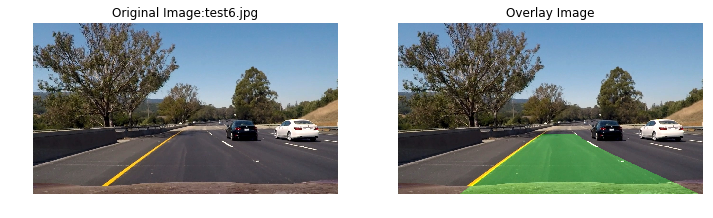

In [45]:
def overlay_warped_image(undist_img, warped, Minv, left_fitx, right_fitx, ploty):
    
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print ("pts left shape:", pts_left.shape, ", pts left:", pts_left)
    #print ("pts right shape:", pts_right.shape, ", pts right:", pts_right)
    #print ("points shape:", pts.shape, ", points:" , np.int_([pts]))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    
    return result

def test_overlay_warped_image():
    images = glob.glob('test_images/*.jpg')
    M = perspective_transform();
    Minv = np.linalg.inv(M)
    for filename in images:
        img = plt.imread(filename)
        undistort = cal.undistort(img)
        warped = warpperspective_transform(undistort, M)
        binary_warped = binary_transform(warped, 31)
        out_img, radius, m_offset, left_x, right_x, ploty = detect_lanes(binary_warped)
        overlay_img =  overlay_warped_image(img, out_img, Minv, left_x, right_x, ploty)
        
        plt.figure(figsize=(12, 8))
        plt.subplot(1, 2, 1)
        plt.axis('off')
        plt.title('Original Image:' + filename.split('/')[-1])
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.axis('off')
        plt.title('Overlay Image')
        plt.imshow(overlay_img)
        plt.show()
        
test_overlay_warped_image()     

In [66]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

g_warped_img = None
CACHE_SIZE = 20 # assuming 20 fps 
g_left_cache = None
g_right_cache = None

M = perspective_transform();
Minv = np.linalg.inv(M)

In [68]:
def advance_lane_detection(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    global g_warped_img, g_left_cache, g_right_cache
    undistort = cal.undistort(img)
    warped = warpperspective_transform(undistort, M)
    binary_warped = color_transform(warped, 31)
    out_img, radius, m_offset, left_x, right_x, ploty = detect_lanes(binary_warped)
    #overlay_img =  overlay_warped_image(img, out_img, Minv, left_x, right_x, ploty)
    if g_warped_img is None :
        g_warped_img = binary_warped
    
    #Someone suggested in slack channel to use matchShape
    ret = cv2.matchShapes(g_warped_img, binary_warped, 1, 0.0)
    if ret < 20:
        g_warped_img = binary_warped
        
        if g_left_cache is None :
            g_left_cache = np.array([left_x])
        if g_right_cache is None :
            g_right_cache = np.array([right_x])
        
        g_left_cache = np.append(g_left_cache, [left_x], axis=0)[-CACHE_SIZE:]
        g_right_cache = np.append(g_right_cache, [right_x], axis=0)[-CACHE_SIZE:]
        
    left_x_mean = np.mean(g_left_cache, axis=0)
    right_x_mean = np.mean(g_right_cache, axis=0)
    overlay_img =  overlay_warped_image(img, out_img, Minv, left_x_mean, right_x_mean, ploty)
    radius_string = "Radius of curvature: %.2f m" % radius
    offset_string = "Center offset: %.2f m" % m_offset
    
    cv2.putText(overlay_img, radius_string, (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), thickness=2)
    cv2.putText(overlay_img, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), thickness=2)
    
    return overlay_img

In [69]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(advance_lane_detection) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [03:35<00:00,  5.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 4min 3s, sys: 54.9 s, total: 4min 58s
Wall time: 3min 36s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [1]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

NameError: name 'HTML' is not defined

In [72]:
challenge_output = 'challenge_video_out.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
yellow_clip = clip2.fl_image(advance_lane_detection)
%time yellow_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_out.mp4
[MoviePy] Writing video challenge_video_out.mp4


100%|██████████| 485/485 [01:22<00:00,  6.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_out.mp4 

CPU times: user 1min 33s, sys: 20.6 s, total: 1min 54s
Wall time: 1min 23s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

## Conclusion

This project is always fun to work. Most of the time consumed in tuning parameters via trail and error method. I need a more time to work around all these trail and error point selection for threshold binary and perspective transform.

Also my implementation is not working on challenge video due to the issue with histogram approach to detect the lanes. Which has multiple peaks in challenge video frames. Need a way to avoid these peaks. 